## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, work will be done to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`1.` Read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
ab_data = pd.read_csv('ab_data.csv')
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
ab_data.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
users = ab_data.user_id.nunique()
users

290584

d. The proportion of users converted.

In [5]:
converted_users = ab_data[ab_data['converted'] == 1].shape[0] / users
converted_users

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
mask1 = (ab_data.group == 'treatment') & (ab_data.landing_page == 'old_page')
mask2 = (ab_data.group == 'control') & (ab_data.landing_page == 'new_page')
t_old_page = ab_data[mask1 | mask2].shape[0]
t_old_page

3893

f. Do any of the rows have missing values?

In [7]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
mask3 = mask1 | mask2
df2 = ab_data[~mask3]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
users = df2.user_id.nunique()
users

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
user_id_dups = df2[df2.user_id.duplicated()].user_id
user_id_dups

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
user_row_dups = df2[df2.user_id == 773192]
user_row_dups

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(2893)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
prob_converted = df2[df2.converted == 1].shape[0] / users
prob_converted

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
prob_control_converted = df2[(df2.group == 'control') & (df2.converted == 1)].shape[0] / df2[df2.group == 'control'].shape[0]
prob_control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
prob_treatment_converted = df2[(df2.group == 'treatment') & (df2.converted == 1)].shape[0] / df2[df2.group == 'treatment'].shape[0]
prob_treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
prob_new_page = df2[df2.landing_page == 'new_page'].shape[0] / users
prob_new_page

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

I do not think that there is sufficient evidence to say that the new page will lead to more conversions for a few reasons, even though the number of users who received the new page was equivalent to the number of users who received the old page which makes this test quite fair. First of all, the probabilities of conversion for both groups were very similar [P(converted|control) = 0.1204, P(converted|treatment) = 0.1188]. These probabilities were not normalized for comparison and they are also very close to the probability of converting irrespective of the `landing_page`. The probabilities obtained here are sufficient to understand whether the sample used is representative of the population. However, they should not form the basis for a decision about the population without performing the necessary tests, such as a hypothesis test.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$
$$H_1: p_{old} - p_{new} \lt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new_convert_rate = df2.converted.mean()
p_new_convert_rate

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old_convert_rate = df2.converted.mean()
p_old_convert_rate

0.11959708724499628

c. What is $n_{new}$?

In [20]:
new_page = df2.query('landing_page == "new_page"')
n_new = new_page.shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
old_page = df2.query('landing_page == "old_page"')
n_old = old_page.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = df2.sample(n_new, replace=True)
new_page_converted = new_page_converted.query('landing_page == "new_page"')

In [23]:
p_new = new_page_converted['converted'].mean()
p_new

0.11865406510198763

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = df2.sample(n_old, replace=True)
old_page_converted = old_page_converted.query('landing_page == "old_page"')

In [25]:
p_old = old_page_converted['converted'].mean()
p_old

0.12138520971302429

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
obs_diff = prob_treatment_converted - prob_control_converted
obs_diff

-0.0015782389853555567

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []
new_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted - old_converted

In [28]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

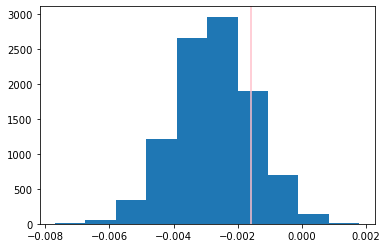

In [29]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color='pink')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

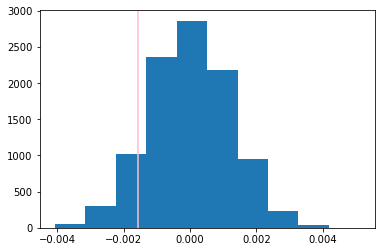

In [30]:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(null_vals);
plt.axvline(obs_diff, color='pink')

In [31]:
p_value = (null_vals > obs_diff).mean()
p_value

0.9037

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

In part __j__, I simulated from the closest value to the alternative space of values that is still in the null space by drawing random samples from a normal distribution defined by that value, the standard deviation of the difference in mean conversion rates statistic, and the number of difference in means I obtained by bootstrap sampling. I used `null_vals` sampling distribution to calculate the __p_value__. The __p_value__ is the probability of obtaining the observed statistic or one more extreme in favour of the alternative hypothesis, assuming that the null hypothesis is true. In my scenario, this means that it is the probability of obtaining a value greater than or equal to `obs_diff`, which is the difference in conversion rates for the new page and old page recipients.

Considering the type 1 error $\alpha = 0.05$ and the p-value obtained using the simulation under the null, I could now state that we fail to reject the null hypothesis. The results of the test are not statistically significant as the p-value is greater than the type 1 error. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
# I needed both import statements as one of them sometimes gave rise to errors
import statsmodels as sm
import statsmodels.api as sma

In [33]:
successes_old = df2[(df2.landing_page == "old_page") & (df2.converted == 1)].converted.count()
successes_new = df2[(df2.landing_page == "new_page") & (df2.converted == 1)].converted.count()

m. Use `stats.proportions_ztest` to compute the test statistic and p-value.

In [34]:
stat, p_val = sm.stats.proportion.proportions_ztest([successes_old, successes_new], [n_old, n_new], alternative='smaller')
stat, p_val

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>The p-value computed in part __m.__ is the same as the p-value of the simulation under the null to 2 decimal places and therefore it agrees with the findings in parts __j.__ and __k.__. The results of the test are not statistically significant, because the p-value is greater than the type 1 error $\alpha = 0.05$.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

__Logistic Regression__

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(columns='control', inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [36]:
logit_mod = sma.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:44:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

In [38]:
np.exp(-0.0150)

0.9851119396030626

In [39]:
1/np.exp(-0.0150)

1.015113064615719

The p-value associated with ab_page is equal to 0.190 to 3 decimal places. It differs from my earlier p-value because it is associated with $H_0: b_1 = 0$ and $H_1: b_1 \neq 0$ not with $H_0: p_{old} - p_{new} \geq 0$ and $H_1: p_{old} - p_{new} \lt 0$. The quantity $b_1$ can be interpreted as follows, if an individual receives the old page (i.e that person is in the control group) he/she is 1.015 times more likely to convert as opposed to an individual who received the new page. $b_1$ can also be seen as the probability (0.985) that an individual converts given that he/she received the new page. By reordering the terms in the hypostheses of __Part II__ we see that they become $H_0: p_{old} \geq p_{new}$ and $H_1: p_{old} \lt p_{new}$. Therefore, $b_1$ here is synonymous with $p_{new}$. By looking at the p-value associated with ab_page at a 95% confidence level we can see that we fail to reject the null hypothesis. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Different factors, other than the page a user receives, may affect their decision regarding conversion such as age or gender. However, some disadvantages may arise such as multicollinearity with the existing or other newly added factors. A linear relationship between the newly added explanatory variables and the response variable may not even exist. Moreover, the presence of outliers in the explanatory variable may undermine the credibility of the predicted response values.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns -  Provide the statistical output as well as a written response to answer this question.

In [40]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [41]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [42]:
### Create the necessary dummy variables
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,ca,uk,us
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [43]:
logit_mod = sma.Logit(df_new['converted'], df_new[['intercept', 'us', 'ca']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:               1.521e-05
Time:                        19:44:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
us            -0.0099      0.013     -0.746      0.456      -0.036       0.016
ca            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

In [44]:
np.exp(-0.0099), np.exp(-0.0507)

(0.9901488436829572, 0.9505637969004034)

In [45]:
1/np.exp(-0.0099), 1/np.exp(-0.0507)

(1.009949167117542, 1.052007243765014)

By looking at the summary we can see that an individual in the uk is 1.010 times and 1.052 times more likely to convert than an individual in the us or in ca. The p-values associated with us and ca at a 95% confidence level show that we failed to reject the null hypotheses ($H_0: b_{us} = 0$ and $H_0: b_{ca} = 0$). Consequently, this means that political location does not affect the response variable (conversion rate).

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
df_new['us_ab_page'] = df_new['us'] * df_new['ab_page']
df_new['ca_ab_page'] = df_new['ca'] * df_new['ab_page']

In [47]:
### Fit Your Linear Model And Obtain the Results
logit_mod = sma.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'us', 'ca', 'us_ab_page', 'ca_ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:44:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
us             0.0057      0.019      0.306      0.760      -0.031       0.043
ca            -0.0118      0.040     -0.296      0.767      -0.090       0.066
us_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
ca_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

In [48]:
np.exp(results.params)

intercept     0.136392
ab_page       1.010893
us            1.005761
ca            0.988285
us_ab_page    0.969090
ca_ab_page    0.924703
dtype: float64

In [49]:
1/np.exp(results.params)

intercept     7.331806
ab_page       0.989224
us            0.994272
ca            1.011854
us_ab_page    1.031896
ca_ab_page    1.081428
dtype: float64

The probabilities predicted by this model in comparison to the previous two models did not change by a significant factor. The p-values for `ab_page`, `us`, `ca`, `us_ab_page`, `ca_ab_page` at a 95% confidence level show that we have failed to reject their corresponding null hypotheses as well. This signifies that the combination of these explanatory variables was not helpful in gaining more information to predict the response variable. The p-values also show that political location (countries) did not affect the conversion rate. In addition, although the interaction variables had much lower p-values, those p-values were still greater than the type 1 error $\alpha = 0.05$.

<a id='conclusions'></a>
## Conclusions

The results obtained from the sample used in this notebook indicate that the new page is not a cause for higher conversion rates as we failed to reject the null hypothesis. Finally, with regard to all tests done in this project, we conclude that the conversion rate for the old page is at least equal to the conversion rate of the new page if not greater than it. Therefore, there is no need to change the landing page of the e-commerce website.

### Resources
- [Statsmodels](https://www.statsmodels.org/stable/index.html)
- [Math Stackexchange](https://math.stackexchange.com/)
- [Stack Overflow](https://stackoverflow.com/)
- [Markdown1](https://rpruim.github.io/s341/S19/from-class/MathinRmd.html)
- [Markdown2](https://www.stevesque.com/symbols/)